# AAPL Single-Expiry Demo: VolCurve + ProbCurve

This notebook is a full walk-through of the single-expiry API using the bundled
AAPL CSV data.

Goals:
- Fit a VolCurve to one expiry
- Inspect smile diagnostics and parameters
- Price options and compute Greeks
- Derive the ProbCurve and query tail probabilities and moments

## Setup

We will:
1) Load the AAPL chain from `data/AAPL_data.csv`
2) Standardize columns with `sources.from_csv`
3) Fit a `VolCurve` for a single expiry
4) Build a `ProbCurve` from the fitted smile

In [1]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oipd import VolCurve, MarketInputs, sources

## Load and filter the AAPL chain

We standardize the column names so `expiry` and `option_type` are recognized by the
library. Then we filter down to a single expiry.

In [14]:
COLUMN_MAPPING = {
    "strike": "strike",
    "last_price": "last_price",
    "bid": "bid",
    "ask": "ask",
    "expiration": "expiry",
    "type": "option_type",
}

df_aapl = sources.from_csv("data/AAPL_data.csv", column_mapping=COLUMN_MAPPING)

# The date that we're interested in (select the expiry date of the option)
expiry = "2026-01-16"
df_expiry = df_aapl[df_aapl["expiry"] == expiry].copy()

## Market inputs

These inputs anchor the smile in time and price. Think of them as the
macroeconomic "state" needed to interpret the options data.

In [15]:
market = MarketInputs(
    valuation_date=date(2022, 1, 16),
    risk_free_rate=0.04,
    underlying_price=256.69,
)

## Fit the VolCurve

The VolCurve is a single-expiry object. Once fitted, it can be queried like a
function: `vol_curve(K)` returns implied volatility at strike K.

In [16]:
vol_curve = VolCurve(method="svi", pricing_engine="black76")
vol_curve.fit(df_expiry, market)

summary = {
    "expiry": vol_curve.expiries[0],
    "forward_price": vol_curve.forward_price,
    "atm_vol": vol_curve.atm_vol,
    "diagnostics": vol_curve.diagnostics,
}
summary

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/interface/volatility.py:154: UserWarning: Filled 16 missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(


{'expiry': datetime.date(2026, 1, 16),
 'forward_price': 260.2520366818154,
 'atm_vol': nan,
 'diagnostics': None}

## Evaluate the smile

We compare the explicit `implied_vol` method to the `__call__` alias, then compute
prices and Greeks across a small strike grid.

In [17]:
from typing import Any


strikes = np.array([220.0, 240.0, 260.0, 280.0, 300.0])

iv = vol_curve.implied_vol(strikes)
total_var = vol_curve.total_variance(strikes)

smile_eval = pd.DataFrame(
    {
        "strike": strikes,
        "iv": iv,
        "total_variance": total_var,
    }
)
smile_eval

,strike,iv,total_variance
0,220.0,0.082648,0.027342
1,240.0,0.075762,0.022975
2,260.0,0.070581,0.019940
3,280.0,0.067006,0.017971
4,300.0,0.064904,0.016862


In [6]:
call_prices = vol_curve.price(strikes, call_or_put="call")
put_prices = vol_curve.price(strikes, call_or_put="put")

# Bulk Greeks
all_greeks = vol_curve.greeks(strikes, call_or_put="call")
all_greeks["call_price"] = call_prices
all_greeks["put_price"] = put_prices
all_greeks

,strike,delta,gamma,vega,theta,rho,call_price,put_price
0,220.0,0.996386,0.000654,0.258945,-7.947481,-0.403868,36.852998,0.014432
1,240.0,0.968648,0.007398,1.875461,-30.682727,-0.185887,16.962169,0.114838
2,260.0,0.331446,0.052100,9.752196,-115.254197,-0.016415,1.497896,4.641801
3,280.0,0.006927,0.002159,0.519134,-7.877703,-0.000219,0.019999,23.155138
4,300.0,0.000493,0.000146,0.047131,-0.961328,-0.000017,0.001543,43.127917


## Visualize the fitted smile

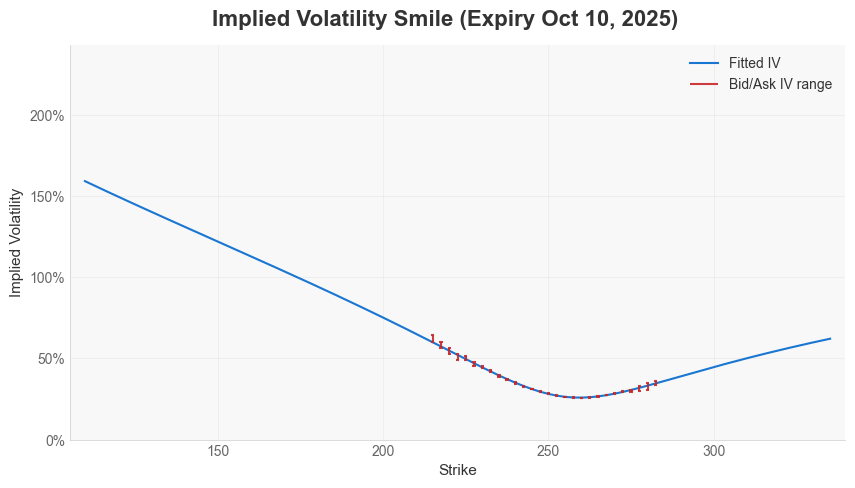

,strike,fitted_iv,market_iv,market_bid_iv,market_ask_iv,market_last_iv
0,109.750000,1.593648,NaN,NaN,NaN,NaN
1,110.883166,1.582701,NaN,NaN,NaN,NaN
2,112.016332,1.571793,NaN,NaN,NaN,NaN
3,113.149497,1.560924,NaN,NaN,NaN,NaN
4,114.282663,1.550091,NaN,NaN,NaN,NaN


In [7]:
vol_curve.plot(include_observed=True)
plt.show()

vol_curve.iv_results().head()

## Build the ProbCurve

The probability curve is the risk-neutral distribution implied by the fitted
smile. You can query tail probabilities, quantiles, and moments.

In [18]:
prob_curve = vol_curve.implied_distribution()

In [ ]:
spot = market.underlying_price
print(spot) # $256.69


prob_below = prob_curve.prob_below(240) # calculates Prob(price at expiry < 240)
prob_above = prob_curve.prob_above(280) # calculates Prob(price at expiry >= 280)
prob_between = prob_curve.prob_between(240, 280)

quantiles = {
    "q10": prob_curve.quantile(0.10),
    "q50": prob_curve.quantile(0.50),
    "q90": prob_curve.quantile(0.90),
}

moments = {
    "mean": prob_curve.mean(),
    "variance": prob_curve.variance(),
    "skew": prob_curve.skew(),
    "kurtosis": prob_curve.kurtosis(),
}

{
    "prob_below": prob_below,
    "prob_above": prob_above,
    "prob_between": prob_between,
    **quantiles,
    **moments,
}

256.69


{'prob_below': 0.2713433801541145,
 'prob_above': 0.29612548997930743,
 'prob_between': 0.43253112986657805,
 'q10': 213.55101391252654,
 'q50': 261.8412550293315,
 'q90': 306.11460227415057,
 'mean': 259.9531995650342,
 'variance': 1367.185055891649,
 'skew': -0.0697762706137478,
 'kurtosis': 0.56083981726555}

## Inspect the grid and plot the distribution

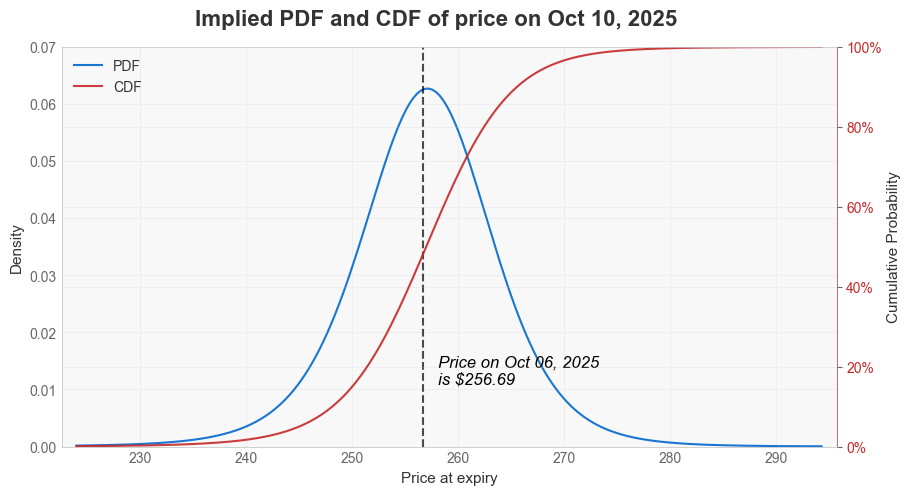

In [11]:
prob_curve.plot(kind="both")
plt.show()

In [ ]:
prob_curve.

TypeError: ProbCurve.pdf() missing 1 required positional argument: 'price'

## Wrap-up

You now have a complete single-expiry workflow:
- Calibrate a VolCurve
- Use it for pricing and risk (Greeks)
- Extract the implied risk-neutral distribution

Next: see the multi-expiry surface notebook for term-structure and interpolation.